In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from glob import glob
import scipy.signal as signal

In [2]:

def filter_timeseries(ts, order, cutoff, btype='lowpass', fs=1, **kwargs):
    """Given an array, this function apply a butterworth (high/low pass) 
    filter of the given order and cutoff frequency.
    For example:
    If 'ts' is a timeseries of daily samples, filter_timeseries(ts,3,1/20)
    will return the series without the 20 days or less variability using an
    order 3 butterworth filter. 
    In the same way, filter_timeseries(ts,3,1/20, btype='highpass') will
    return the series with only the 20 days or less variability.

    Args:
        ts (array_like): timeseries or 1D array to filter
        order (int): _description_
        cutoff (array_like): Single float for lowpass or highpass filters, 
        arraylike for bandpass filters.
        btype (str, optional): The type of filter. Defaults to 'lowpass'.
        fs (int): Sampling frequency. Defaults to 1
        **kwargs are passed to scipy.signal.filtfilt

    Returns:
        output (array): Filtered array
    """
    mask = np.isnan(ts)
    nans = np.ones(len(ts))*np.nan
    if mask.sum()==len(ts):
        return nans
    else:
        b, a = signal.butter(order, cutoff, btype=btype, fs=fs)
        filt=signal.filtfilt(b, a, ts[~mask], padlen=30*max(len(a),len(b)), **kwargs)
        output=np.ones(len(ts))*np.nan
        output[np.where(~mask)] = filt
        return output
    
def filter_xarray(data, dim, order, cutoff, btype='lowpass', parallel=False, fs=1):
    """Given a 3d DataArray, with time and spatial coordinates, this function apply
    the 1D function filter_timeseries along the time dimension, filter the complete
    xarray data.

    Args:
        data (XDataArray): data
        dim (str): name of the time dimension
        order (int): butterworth filter order
        cutoff (array_like): if float, the cutoff frequency, if array must be the
                            [min,max] frequencys for the bandpass filter.
        btype (str, optional): {lowpass,highpass,bandpass}. Defaults to 'lowpass'.
        parallel (bool, optional): If parallelize with dask. Defaults to False.
        fs (int, optional): Sampling frequency. Defaults to 1.

    Returns:
        XDataArray: filtered data
    """
    if parallel:
        dask='parallelized'
    else:
        dask='forbidden'
    filt = xr.apply_ufunc(filter_timeseries, data, order, cutoff, btype, fs,
                          input_core_dims=[[dim],[],[],[],[]],
                          output_core_dims=[[dim]],
                          exclude_dims=set((dim,)),
                          keep_attrs=True,
                          vectorize=True, dask=dask)
    filt[dim] = data[dim]
    return filt


def compute_climatology(data, dim='time', order=5, cutoff=1/90):
    """
    This function computes a daily climatology with the following method:
    1) Transform calendar to 'noleap' (same as remove 29 feb)
    2) Compute the daily average
    3) Repeat the daily (noisy) climatology for 30 years
    4) Smooth with a lowpass filter
    5) Compute again the daily average and return
    
    
    Args:
        data (xarray): dataset or datarray for climatology computing
        dim (str, optional): Name of the time dimension. Defaults to 'time'.
        order (int, optional): Butterworth filter order. Defaults to 5.
        cutoff (float, optional): Cutoff frequency. Defaults to 1/80.

    Returns:
        _type_: _description_
    """
    clim = data.convert_calendar('noleap', dim=dim)
    clim = clim.groupby(dim+'.dayofyear').mean()
    clim = xr.concat([clim]*30, 'dayofyear')
    clim.coords[dim] = ('dayofyear',xr.date_range('2000','2030', calendar='noleap')[:-1])
    clim = clim.swap_dims({'dayofyear':dim}).drop('dayofyear')
    clim = filter_xarray(clim, dim, order, cutoff)
    clim = clim.groupby(dim+'.dayofyear').mean()
    return clim



---
##### glorys

In [3]:
tropical_glorys       = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_tropical.nc').convert_calendar('noleap', dim='time')
tropical_reforecast   = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_tropical.nc').convert_calendar('noleap', dim='inittime')

coastnorth_glorys     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_coastnorth.nc').convert_calendar('noleap', dim='time')
coastnorth_reforecast = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_coastnorth.nc').convert_calendar('noleap', dim='inittime')

coastsouth_glorys     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_coastsouth.nc').convert_calendar('noleap', dim='time')
coastsouth_reforecast = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_coastsouth.nc').convert_calendar('noleap', dim='inittime')

In [4]:
tropical_clim   = compute_climatology(tropical_glorys, cutoff=1/90)
coastnorth_clim = compute_climatology(coastnorth_glorys, cutoff=1/90)
coastsouth_clim = compute_climatology(coastsouth_glorys, cutoff=1/90)


In [5]:
tropical_clim.to_netcdf('/home/lucas/storage/glorys_tropical.nc')
coastnorth_clim.to_netcdf('/home/lucas/storage/glorys_coastnorth.nc')
coastsouth_clim.to_netcdf('/home/lucas/storage/glorys_coastsouth.nc')

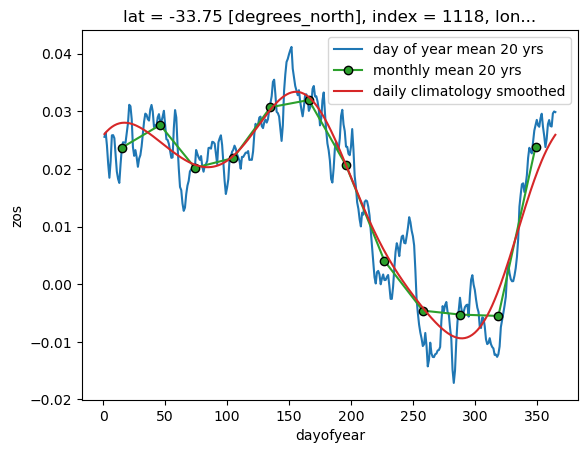

In [6]:
plt.figure(facecolor='w', dpi=100)
coastsouth_glorys.zos.isel(index=380).groupby('time.dayofyear').mean().plot(label='day of year mean 20 yrs ')
clim2=coastsouth_glorys.zos.isel(index=380).groupby('time.month').mean()
clim2.coords['dayofyear'] = ('month',np.array([15,46,74,105,135,166,196,227,258,288,319,349]))
clim2.plot(x='dayofyear', marker='o', markeredgecolor='k', color='tab:green', label='monthly mean 20 yrs')
coastsouth_clim.zos.isel(index=380).plot(color='tab:red', label='daily climatology smoothed')
plt.legend()

---
### reforecasts

In [ ]:
tropical_reforecast_clim   = []
coastnorth_reforecast_clim = []
coastsouth_reforecast_clim = []
for lead in range(len(tropical_reforecast.leadtime)):
    print(lead)
    data = tropical_reforecast.sel(leadtime=lead)
    data.coords['time'] = ('inittime', data.inittime.values+pd.Timedelta(days=lead))
    data = data.swap_dims({'inittime':'time'}).drop('inittime').drop_duplicates('time')#.groupby('time.dayofyear').mean()
    data = data.interp({'time':xr.date_range(data.time[0].dt.strftime('%F').item(),data.time[-1].dt.strftime('%F').item(),calendar='noleap')})
    data = compute_climatology(data)
    tropical_reforecast_clim.append(data)
    
    data = coastnorth_reforecast.sel(leadtime=lead)
    data.coords['time'] = ('inittime', data.inittime.values+pd.Timedelta(days=lead))
    data = data.swap_dims({'inittime':'time'}).drop('inittime').drop_duplicates('time')#.groupby('time.dayofyear').mean()
    data = data.interp({'time':xr.date_range(data.time[0].dt.strftime('%F').item(),data.time[-1].dt.strftime('%F').item(),calendar='noleap')})
    data = compute_climatology(data)
    coastnorth_reforecast_clim.append(data)
    
    data = coastsouth_reforecast.sel(leadtime=lead)
    data.coords['time'] = ('inittime', data.inittime.values+pd.Timedelta(days=lead))
    data = data.swap_dims({'inittime':'time'}).drop('inittime').drop_duplicates('time')#.groupby('time.dayofyear').mean()
    data = data.interp({'time':xr.date_range(data.time[0].dt.strftime('%F').item(),data.time[-1].dt.strftime('%F').item(),calendar='noleap')})
    data = compute_climatology(data)
    coastsouth_reforecast_clim.append(data)
    
tropical_reforecast_clim   = xr.concat(tropical_reforecast_clim, 'leadtime')
coastnorth_reforecast_clim = xr.concat(coastnorth_reforecast_clim, 'leadtime')
coastsouth_reforecast_clim = xr.concat(coastsouth_reforecast_clim, 'leadtime')

In [ ]:
plt.figure(facecolor='w', dpi=100)
coastsouth_reforecast.zos.isel(index=17, leadtime=0).groupby('inittime.dayofyear').mean().plot(label='day of year mean 20 yrs ')
clim2=coastsouth_reforecast.zos.isel(index=17, leadtime=0).groupby('inittime.month').mean()
clim2.coords['dayofyear'] = ('month',np.array([15,46,74,105,135,166,196,227,258,288,319,349]))
clim2.plot(x='dayofyear', marker='o', markeredgecolor='k', color='tab:green', label='monthly mean 20 yrs')
coastsouth_reforecast_clim.zos.isel(index=17, leadtime=0).plot(color='tab:red', label='daily climatology smoothed')
plt.legend()

In [ ]:
fig = plt.figure(facecolor='w', dpi=100, figsize=(10,5))
ax = fig.add_subplot(111)
y = coastsouth_reforecast_clim.zos.isel(index=17)

colors=plt.cm.Greys(np.linspace(0.15,1, len(y.leadtime)))
for i,lead in enumerate(y.leadtime):
    y.sel(leadtime=lead).plot(color=colors[i], ax=ax)
    ax.set_title('')
m = plt.cm.ScalarMappable(cmap='Greys', norm=mcolors.Normalize(0,45))
fig.colorbar(m, label='leadtime')


In [ ]:
coastsouth_reforecast_clim.to_netcdf('data/S2S/CLIMATOLOGY/reforecasts_coastsouth_clim.nc')
coastnorth_reforecast_clim.to_netcdf('data/S2S/CLIMATOLOGY/reforecasts_coastnorth_clim.nc')
tropical_reforecast_clim.to_netcdf('data/S2S/CLIMATOLOGY/reforecasts_tropical_clim.nc')